#INSTALL MPENV

In [1]:
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
%%capture
!git clone https://github.com/Daetheys/nmprepr
%cd nmprepr
!git checkout bfs_depth_initial_position
!mamba env update -n base -f environment.yml
!pip3 install -U colabgymrender

Little Hack to make it work

In [4]:
!cp -RT /content/nmprepr/mpenv /usr/local/lib/python3.7/site-packages/mpenv
!cp -RT /content/nmprepr/nmp /usr/local/lib/python3.7/site-packages/nmp
!cp -RT /content/nmprepr/curriculum /usr/local/lib/python3.7/site-packages/curriculum

In [5]:
import gym
from gym.envs.registration import register

from IPython.display import clear_output

from curriculum.maze_trainer import MazeTrainer
from curriculum.curriculum_trainer import CurriculumTrainer
from curriculum.utils import remove_all_nmprepr_gym_envs

No personal conf_private.py found.
doodad not detected


## New curriculum

In [6]:
max_maze_size = [2, 5, 2, 5, 2, 5, 3, 5, 3, 5, 3, 5]
depth =         [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
min_gap = .17

In [7]:
%%capture
remove_all_nmprepr_gym_envs()

In [8]:
env_list = []
for i in range(len(depth)):
  d = depth[i]
  m = max_maze_size[i]
  M = max_maze_size[i]
  register(
    id=f"Maze-i{i}d{d}M{M}-v0",
    entry_point="mpenv.envs.maze:maze_edges",
    kwargs={"grid_size": 1, "easy":True, "coordinate_jitter":True, "min_gap": min_gap, 
            "depth_max":d,  "min_maze_size":m, "max_maze_size":M, "depth_specified":True},
  )
  env_list.append(f"Maze-i{i}d{d}M{M}-v0")

register(
    id=f"Maze-Simple-v0",
    entry_point="mpenv.envs.maze:maze_edges",
    kwargs={"grid_size": 3},
)
register(
    id=f"Maze-Medium-v0",
    entry_point="mpenv.envs.maze:maze_edges",
    kwargs={"grid_size": 5},
)
register(
    id=f"Maze-Hard-v0",
    entry_point="mpenv.envs.maze:maze_edges",
    kwargs={"grid_size": 7},
)
env_list.insert(11,'Maze-Simple-v0')
env_list.append('Maze-Medium-v0')

In [ ]:
for e in env_list:
    env = gym.make(e)
    env.reset()
    env.render()

In [ ]:
env_list

In [ ]:
trainer = CurriculumTrainer(env_list,
                        batch_size=256,
                        hidden_dim=256,
                        nb_layers=3,
                        lr=3e-4,
                        horizon=75,
                        threshold=0.65,
                        count_next_threshold=2,
                        num_expl_steps_per_train_loop=1000,
                        num_eval_steps_per_epoch = 1000,
                        min_num_steps_before_training=1000,
                        num_trains_per_train_loop=1000,
                        #replay_buffer_size=int(1e5),
                        n_viz_path=None,
                       load_replay_buffer_file=None,
                       archi='pointnet',
                       save_replay = False,
                       timeout_threshold=30
                       )
trainer.train()

# NSNetworks

## Import

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

torch.set_default_dtype(torch.float32)

## Model

In [ ]:
def trace(input, axis1=0, axis2=1):
    #Computes the trace of a multidimension array over two given axes
    assert input.shape[axis1] == input.shape[axis2], input.shape

    shape = list(input.shape)
    strides = list(input.stride())
    strides[axis1] += strides[axis2]

    shape[axis2] = 1
    strides[axis2] = 0

    input = torch.as_strided(input, size=shape, stride=strides)
    return input.sum(dim=(axis1, axis2))

In [ ]:
def set_const(layer,v=0):
    #Sets the parameters of a network to the given value
    for p in layer.parameters():
        p.data = torch.tensor(torch.zeros(p.shape)+v)

In [ ]:
def plot(v, p,div=None,s=None,norm=False):
    # Plot fields v,p,s (obstacles) and div
    width,height = v.shape[2:]
    plt.figure(figsize=(30,30))
    vx = v[0,0]
    vy = v[0,1]
    if norm:
        vnorm = (torch.sum(v[0]**2,dim=0)**0.5)
        vnorm += (vnorm == 0)
        vx = vx/vnorm
        vy = vy/vnorm
    p=p[0,0]
    p = np.log(-p+1.1*p.max())
    p = (p-p.min())/(p.max()-p.min())
    x=np.arange(0,width)
    y=np.arange(0,height)
    x,y = np.meshgrid(x,y)
    plt.quiver(x,y,vx,vy,angles='xy')
    nb = 1+int(not(div is None))+int(not(s is None))
    if not(div is None):
        div = (div-div.min())/(div.max()-div.min())
        plt.imshow(div[0,0],cmap='Blues',alpha=1/nb)
    if not(s is None):
        s = (s-s.min())/(s.max()-s.min())
        plt.imshow(s[0,0],cmap='Reds',alpha=1/nb)
    plt.imshow(p,cmap='Greens',alpha=1/nb)
    plt.colorbar()
    plt.show()

In [ ]:
class PaddedConv2d(nn.Conv2d):
    #Convolution which padds the output with zeros
    def __init__(self,nb_in,nb_out,kernel_size,*args,**kwargs):
        super().__init__(nb_in,nb_out,kernel_size,*args,**kwargs)

        self.pad_fn = nn.ZeroPad2d(kernel_size//2)

    def forward(self,v,*args,**kwargs):
        return self.pad_fn(super().forward(v,*args,**kwargs))

In [ ]:
class ParallelConv(nn.Module):
    #Convolution which processes each channel independantly (usefull to compute derivatives)
    def __init__(self,nb_in,nb_out,concat=False,kernel_size=3):
        super().__init__()

        self.nb_in = nb_in
        self.nb_out = nb_out

        self.concat = concat

        self.convs = [PaddedConv2d(1,nb_out,kernel_size,bias=False) for i in range(nb_in)]

        for i,c in enumerate(self.convs):
            self.register_parameter(name='conv-'+str(i),param=c.weight)

    def forward(self,v):
        res = [self.convs[i](v[...,[i],:,:])[...,None,:,:,:] for i in range(self.nb_in)]

        res = torch.cat(res,axis=-4)
        if self.concat:
            res = torch.reshape(res,(*v.shape[:-3],self.nb_in*self.nb_out,*res.shape[-2:]))

        return res

In [ ]:
class PolynomBlock(nn.Module):
    #Equivalent of bn-an/dt
    def __init__(self,nb_in,order=2):
        super().__init__()

        self.order = order

        self.pconv = ParallelConv(nb_in,2)

        self.params = nn.Parameter(torch.zeros((order,)))

    def forward(self,v):
        matrix = self.pconv(v)

        matrix_permuted = matrix.transpose(-1,-3).transpose(-2,-4)
        
        l_power = []
        o = torch.eye(matrix_permuted.shape[-1])
        for i in range(self.order):
            o = torch.matmul(matrix_permuted,o)
            l_power.append(o[None])

        l_power = torch.cat(l_power,dim=0)

        out = torch.sum(l_power*self.params[:,None,None,None,None,None],dim=0)

        out = trace(out,axis1=-2,axis2=-1)

        out = out[...,None,:,:]

        return out

In [ ]:
class NSBlock(nn.Module):
    #Equivalent of (V.grad)V + nabla.V but more general
    def __init__(self,nb_ch):
        super().__init__()

        self.nb_ch = nb_ch

        self.convlong = ParallelConv(self.nb_ch,1,concat=True) # nabla.V
        self.convshort = ParallelConv(self.nb_ch,self.nb_ch) # gradV

    def forward(self,v):
        long = self.convlong(v) #nabla.V

        short = self.convshort(v) #gradV

        short = torch.sum(v[...,None,:,:]*short,dim=-3) #(V.grad).V
    
        out = short+long #(V.grad)V + nabla.V
        return out

In [ ]:
class NSLayer(nn.Module):
    def __init__(self,dim,p_iter=1):
        super().__init__()

        self.dim = dim
        self.p_iter = p_iter

        self.preconvv = ParallelConv(2,1,concat=True) #grad V
        self.preconvp = PaddedConv2d(1,1,3,bias=False) #homogenise P
        self.preconvs = PaddedConv2d(1,1,3,bias=False) #correct derivatives over walls

        self.polyblock = PolynomBlock(2) #

        self.divlongconv = PaddedConv2d(1,1,3,bias=False) #divergence term
        self.divshortconv = PaddedConv2d(1,2,3,bias=False) #

        self.nsblock = NSBlock(self.dim) #(V.grad)V + nabla.V

        self.convp = ParallelConv(1,self.dim,concat=True) #

    def forward(self,inp):
        (v,p,div,s) = inp
        pre_v = v
        pre_v = self.preconvv(v)

        p_in = p
        for i in range(self.p_iter):
            pre_p = self.preconvp(p_in)
            pre_p *= (1-s)
            pre_s = self.preconvs(1-s)
            pre_p /= pre_s+(pre_s==0).float()

            poly_v = self.polyblock(pre_v)

            divshort = self.divshortconv(div)

            div_influence = self.divlongconv(div) + pre_v[...,[0],:,:]*divshort[...,[0],:,:] + pre_v[...,[1],:,:]*divshort[...,[1],:,:]

            p_out = p

            alpha = 1

            mask_center = torch.zeros(p.shape)
            mask_center[...,1:-1,1:-1] = 1

            mask_border = torch.zeros(p.shape)
            mask_border[...,0,:] = 1
            mask_border[...,-1,:] = 1
            mask_border[...,:,0] = 1
            mask_border[...,:,-1] = 1

            p_out = p_out*mask_border + (poly_v+pre_p +div_influence)*mask_center

            p_out[...,0,:] += alpha*(p_out[...,1,:]-p_out[...,0,:])
            p_out[...,-1,:] += alpha*(p_out[...,-2,:]-p_out[...,-1,:])
            p_out[...,:,0] += alpha*(p_out[...,:,1]-p_out[...,:,0])
            p_out[...,:,-1] += alpha*(p_out[...,:,-2]-p_out[...,:,-1])

            p_in = p_out


        block_v = self.nsblock(pre_v)

        p_add = self.convp(p_out)*(self.preconvs(s)==0)

        v_out = pre_v
        v_out = v_out + block_v + p_add

        v_out = v_out*(1-s)
        p_out *= (1-s)


        return v_out,p_out,div,s

In [ ]:
class NSNetwork(nn.Module):
    def __init__(self,dim,nb_stack=50,same=False,p_iter=1):
        super().__init__()

        self.structure = 'standard'

        self.nb_stack = nb_stack

        if same:
            l = [NSLayer(dim,p_iter=p_iter)]*nb_stack
        else:
            l = []
            for i in range(nb_stack):
                l.append(NSLayer(dim,p_iter=p_iter))

        self.nsll = nn.Sequential(*l)

    def forward(self,v,p,div,s):
        vo,po = v.clone(),p.clone()
        vo,po,div,s = self.nsll((vo,po,div,s))
        return vo,po

## Pyramids

Pyramidal NSNetworks correspond to a way to decrease the stack of NSLayers by solving the given maze first on an downsampled version of it in order to have an idea of where to flow is globally going (faster to compute on low resolution). Then we can upsample the flow computed on the downsampled version of the maze and stack only few layers to correct upsampling issues which should only have a local impact (thus quickly solved by convolutions).

In [ ]:
#INTERPOLATION_MODE = transforms.functional.InterpolationMode.BILINEAR

class UpScale(nn.Module):
    def forward(self,inp):
        im_size = inp.shape[2:]
        tr = transforms.Resize((im_size[0]*2,im_size[1]*2))#,INTERPOLATION_MODE)
        return tr(inp)

class DownScale(nn.Module):
    def forward(self,inp):
        im_size = inp.shape[2:]
        tr = transforms.Resize((im_size[0]//2,im_size[1]//2))#,INTERPOLATION_MODE)
        return tr(inp)

In [ ]:
class PyramidNSNetwork(nn.Module):
    def __init__(self,dim,nb_stack_per_level=[3,5,7,9,11],same=False,p_iter=1):
        super().__init__()

        self.structure = 'pyramid'

        self.nb_stack_per_level = nb_stack_per_level
        self.nb_levels = len(nb_stack_per_level)

        if same:
            l = []
            nsl = NSLayer(dim,p_iter=p_iter)
            for k in nb_stack_per_level:
                l.append([nsl]*k)
        else:
            l = []
            for k in range(self.nb_levels):
                l.append([])
                for i in range(nb_stack_per_level[k]):
                    l[k].append(NSLayer(dim,p_iter=p_iter))
        self.nsll = torch.nn.ModuleList([])
        for k in range(self.nb_levels):
            self.nsll.append(nn.Sequential(*l[k]))
        self.downscale = DownScale()
        self.upscale = UpScale()

    def forward(self,v,p,div,s,nb_stack=None,return_levels=False):
        if nb_stack is None:
            nb_stack=self.nb_levels
        #Compute s and div at each level
        ldiv = [div]
        ls = [s]
        for k in range(nb_stack-1):
            ldiv.append( (self.downscale(ldiv[-1])).double() )
            ls.append( (self.downscale(ls[-1])>0.75).double() )
        ldiv.reverse()
        ls.reverse()
        #Downscale vo po
        vo,po = v.clone(),p.clone()
        for k in range(nb_stack):
            vo,po = self.downscale(vo),self.downscale(po)
        #Run the pyramid
        llevels = []
        for k in range(nb_stack):
            #Upscale fields
            vo = self.upscale(vo)
            po = self.upscale(po)
            vo,po,div,s = self.nsll[k]((vo,po,ldiv[k],ls[k]))
            if return_levels:
                llevels.append((vo,po,ls[k],ldiv[k]))
        if return_levels:
            return vo,po,llevels
        return vo,po

##Preconfig

In [ ]:
pyramid = False
if pyramid:
    stacks = [50,40,30,20]
    nsn = PyramidNSNetwork(2,nb_stack_per_level=stacks,same=True)
    nsl_preconfig = nsn.nsll[0][0]
    print(sum([p.numel() for p in nsl_preconfig.parameters()]))
else:
    nsn = NSNetwork(2,nb_stack=100,same=True)
    nsl_preconfig = nsn.nsll[0]
    print(sum([p.numel() for p in nsl_preconfig.parameters()]))

173


In [ ]:
kdx = torch.tensor([[0,0,0],[-1/2,0,1/2],[0,0,0]],dtype=torch.float32)[None,None]
kdy = torch.tensor([[0,-1/2,0],[0,0,0],[0,1/2,0]],dtype=torch.float32)[None,None]
kddx = torch.tensor([[0,0,0],[1/4,-1/2,1/4],[0,0,0]],dtype=torch.float32)[None,None]
kddy = torch.tensor([[0,1/4,0],[0,-1/2,0],[0,1/4,0]],dtype=torch.float32)[None,None]
smooth = torch.tensor([[0,1/4,0],[1/4,0,1/4],[0,1/4,0]],dtype=torch.float32)[None,None]
identity = torch.tensor([[0,0,0],[0,1,0],[0,0,0]],dtype=torch.float32)[None,None]
sumx = torch.tensor([[0,0,0],[1,0,1],[0,0,0]],dtype=torch.float32)[None,None]
sumy = torch.tensor([[0,1,0],[0,0,0],[0,1,0]],dtype=torch.float32)[None,None]

In [ ]:
def init_ns_net(nsn,dx=1,dy=1,dt=1,rho=1000,mu=10**-6):
    #Init the network to the numerical resolution parameters
    if nsn.structure == 'pyramid':
        nsl_preconfig = nsn.nsll[0][0]
    else:
        nsl_preconfig = nsn.nsll[0]
    nsl_preconfig.preconvv.convs[0].weight = nn.Parameter(smooth)
    nsl_preconfig.preconvv.convs[1].weight = nn.Parameter(smooth)

    nsl_preconfig.preconvp.weight = nn.Parameter( (dx**2*sumx+dy**2*sumy) )

    nsl_preconfig.preconvs.weight = nn.Parameter( (dx**2*sumx+dy**2*sumy) )

    nsl_preconfig.polyblock.pconv.convs[0].weight = nn.Parameter(torch.cat([kdx,kdy],dim=0))
    nsl_preconfig.polyblock.pconv.convs[1].weight = nn.Parameter(torch.cat([kdx,kdy],dim=0))

    nsl_preconfig.polyblock.params = nn.Parameter(torch.tensor([-1/dt,1])*rho*dx**2*dy**2/(2*(dx**2+dy**2)))

    nsl_preconfig.divlongconv.weight = nn.Parameter( rho*dx**2*dy**2/(2*(dx**2+dy**2))*(-mu*(kddx+kddy) + identity/dt))
    nsl_preconfig.divshortconv.weight = nn.Parameter( rho*dx**2*dy**2/(2*(dx**2+dy**2))*torch.cat([kdx,kdy],dim=0) )

    nsl_preconfig.nsblock.convlong.convs[0].weight = nn.Parameter(mu*dt*(kddx+kddy))
    nsl_preconfig.nsblock.convlong.convs[1].weight = nn.Parameter(mu*dt*(kddx+kddy))

    nsl_preconfig.nsblock.convshort.convs[0].weight = nn.Parameter(-dt*torch.cat([kdx,kdy],dim=0))
    nsl_preconfig.nsblock.convshort.convs[1].weight = nn.Parameter(-dt*torch.cat([kdx,kdy],dim=0))

    nsl_preconfig.convp.convs[0].weight = nn.Parameter(-dt/rho*torch.cat([kdx,kdy],dim=0))

In [ ]:
init_ns_net(nsn)

# NS Policy

## Conv Observer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
class ConvObserver:
    #Added on top of a maze environment it will change its output to an image representing obstacles in channel 1, position in channel 2 and goal in channel 3
    def __init__(self,env,dim=256,thickness=15):
        self.env = env
        self.observation_space = gym.spaces.Box(0,1,(dim,dim))
        self.action_space = self.env.action_space
        self.reward_range = self.env.reward_range
        self.metadata = self.env.metadata

        self.thickness = thickness

        self.dim = dim

    def render(self,*args,**kwargs):
        return self.env.render(*args,**kwargs)

    def reset(self):
        o = self.env.reset()
        self.original_o = o
        self.compute_walls(o)
        return self.observation(o)

    def step(self,a):
        o,r,d,i = self.env.step(a)
        self.original_o = o
        return self.observation(o),r,d,i

    def compute_walls(self,o,res=100):
        o = o['observation']
        pos = o[-2:]
        nb = o[-3]
        lwalls = o[:448].reshape((-1,4))
        imwalls = np.zeros((self.dim,self.dim))
        def build_wall(a,b):
            for i in range(res):
                x = np.int64((a+i/res*b)*self.dim)
                for xt in range(-self.thickness//2,self.thickness//2+1):
                    for yt in range(-self.thickness//2,self.thickness//2+1):
                        if 0<=x[0]+xt<self.dim and 0<=x[1]+yt<self.dim:
                            imwalls[x[0]+xt,x[1]+yt] = 1
        for w in range(int(nb)):
            a = lwalls[w,:2]+pos
            b = lwalls[w,2:]+pos-a
            if not(np.all(b==0)):
                build_wall(a,b)
        self.imwalls = imwalls
    
    def observation(self,o):
        #o = self.env.observation()
        impos = np.zeros((self.dim,self.dim))
        pos = np.int8(o['observation'][-2:]*self.dim)
        impos[pos[0],pos[1]] = 1
        imgoal = np.zeros((self.dim,self.dim))
        goal = np.int8( (o['representation_goal']+o['observation'][-2:])*self.dim)
        imgoal[goal[0],goal[1]] =1
        imwalls = self.imwalls
        imwalls = np.transpose(imwalls,(1,0))[::-1]
        impos = np.transpose(impos,(1,0))[::-1]
        imgoal = np.transpose(imgoal,(1,0))[::-1]
        return np.concatenate([imwalls[...,None],impos[...,None],imgoal[...,None]],axis=2)
        


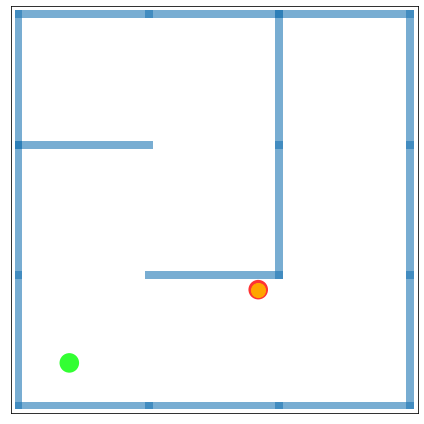

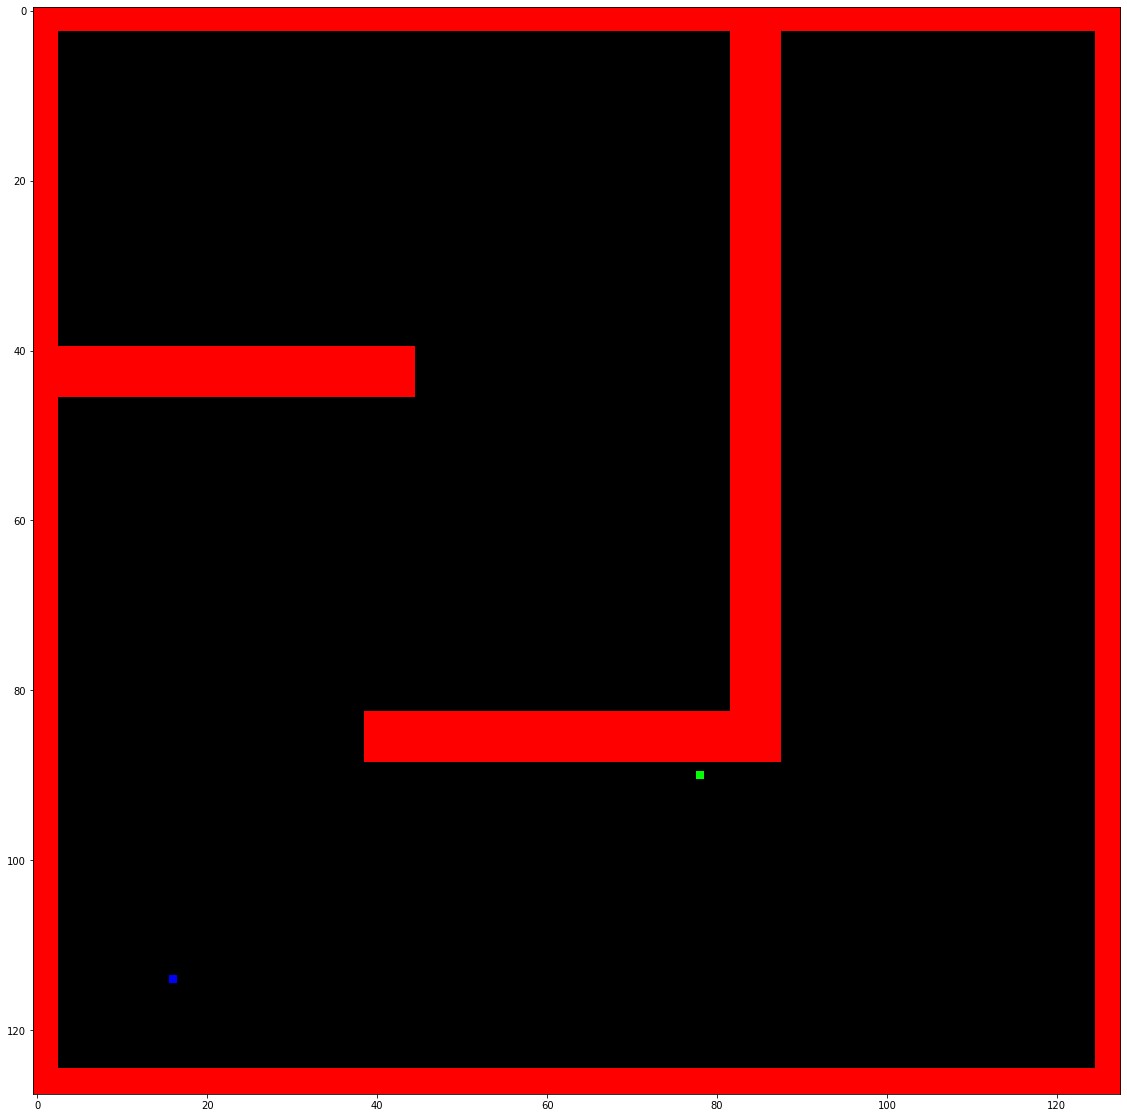

In [ ]:
cobs = ConvObserver(env,dim=128,thickness=5)
o2 = cobs.reset()
cobs.env.render()
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(o2,cmap='Greys')

## Build a preinit fluid solver

In [ ]:
nsn = PyramidNSNetwork(2,nb_stack_per_level=[250],same=True)
init_ns_net(nsn,dt=0.01,mu=10,rho=0.01)

## Run it on the maze

In [ ]:
imwalls = o2[...,0]
impos = o2[...,1]
imgoal = o2[...,2]

s = imwalls
eps = 10**-10
div = eps - imgoal*eps*np.prod(imgoal.shape)

v = np.zeros((2,dim,dim))
p = np.zeros((dim,dim))
#p *= (1-s)

v = torch.tensor(v[None]).float()
p = torch.tensor(p[None,None]).float()
div = torch.tensor(div[None,None]).float()
s = torch.tensor(s[None,None]).float()
with torch.no_grad():
    vo,po,llevels = nsn(*(v,p,div,s),return_levels=True)

tensor(-1.3206e-07) tensor(6.2500e-09)


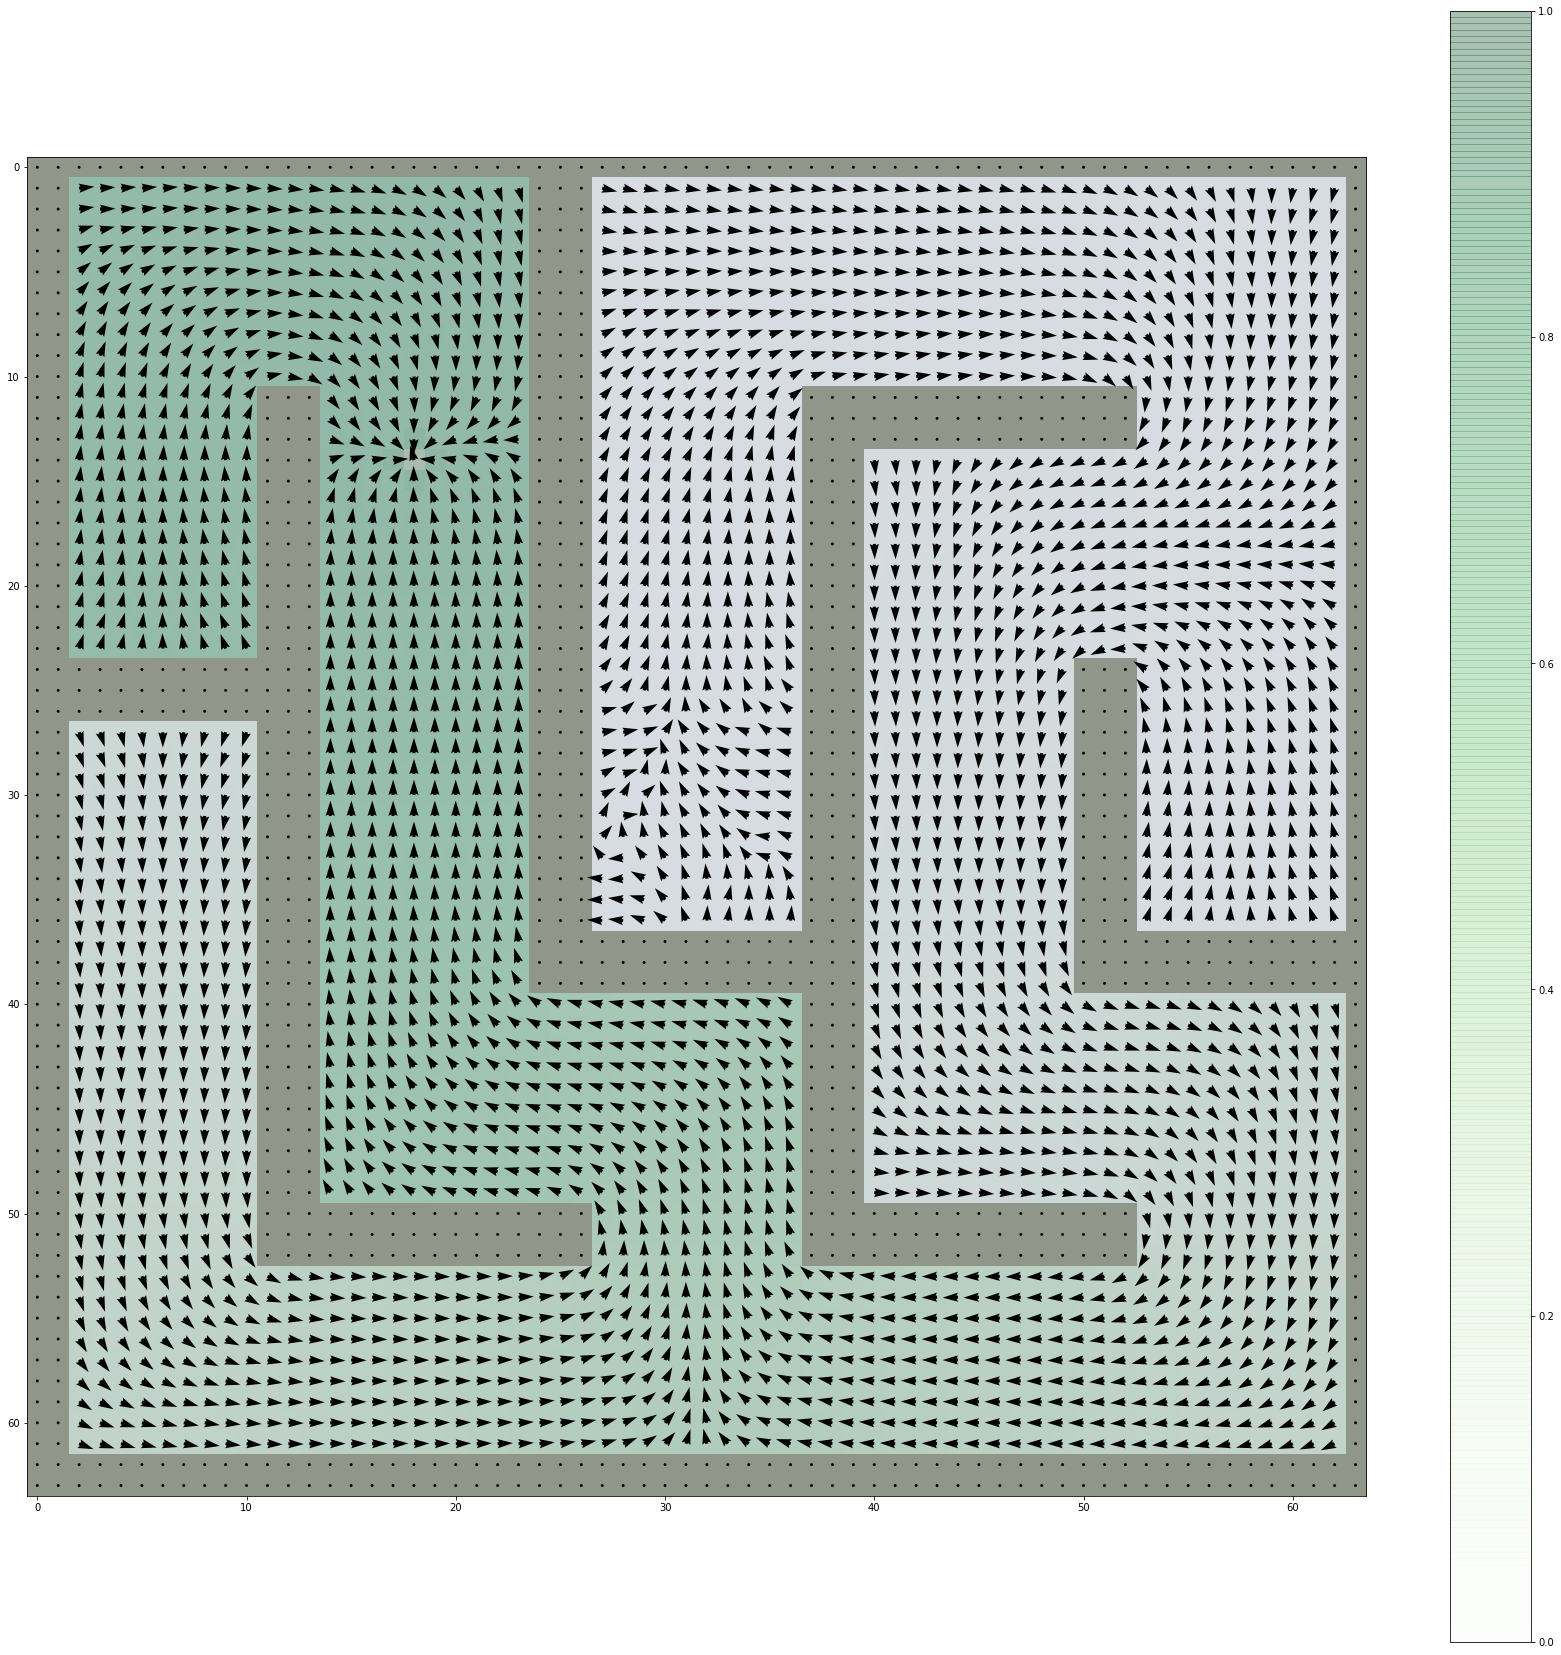

In [ ]:
for vl,pl,sl,divl in llevels:
    print(pl.min(),pl.max())
    plot(vl.detach(),pl.detach(),s=sl,div=divl,norm=True)

## Policy definition

In [ ]:
class TrajectorySampler:
    # Samples trajectory from a fluid field
    def __init__(self,nsn,env):
        self.nsn = nsn
        self.env = env
    def sample(self,n,record=False):
        l = []
        count = 0
        for i in range(n):
            if i%10==9:
                print(i,count)
            path = self.collect(record=record)
            count += len(path['observations'])
            l.append(path)
        return l
    def collect(self,nb_per_env=50,record=False):
        #Generate trajectories
        # -- Runs the fluid solver
        o = self.env.reset()

        imwalls = o[...,0]
        impos = o[...,1]
        imgoal = o[...,2]


        s = imwalls
        eps = 10**-10
        div = eps - imgoal*eps*np.prod(imgoal.shape)

        v = np.zeros((2,dim,dim))
        p = np.zeros((dim,dim))

        v = torch.tensor(v[None]).float()
        p = torch.tensor(p[None,None]).float()
        div = torch.tensor(div[None,None]).float()
        s = torch.tensor(s[None,None]).float()


        with torch.no_grad():
            vo,po = self.nsn(v,p,div,s)
        vo,po = vo.numpy()[0],po.numpy()[0]
        vnorm = np.sum(vo**2,axis=0)**0.5
        vn = vo/(vnorm+np.float32((vnorm==0)))

        idx_exit = np.where(div==div.min())
        if (vn[:,idx_exit[2][0],idx_exit[3][0]]**2).sum() == 0:
            return self.collect(nb_per_env=nb_per_env)

        
        #Run few trajectories from different starting points and store them in the database
        bobservations = []
        bactions = []
        brewards = []
        bnext_observations = []
        bterminals = []
        benv_infos = {}
        bimages = []
        for i in range(nb_per_env):
            count = 75
            done = False
            li = []
            while True:
                #Get new starting point
                self.env.env.env.env.state = self.env.env.env.env.random_configuration() #That's where you see you have too many observers stacked on top on your environment ...
                if not(self.env.env.env.env.is_straight_path(self.env.env.env.env.state,self.env.env.env.env.goal_state)):
                    p = np.int64(self.env.env.env.env.state.q[:2]*self.env.dim)
                    if (vn[:,p[0],p[1]]**2).sum() != 0:
                        break
            observations = []
            actions = []
            rewards = []
            next_observations = []
            terminals = []
            env_infos = {}
            images = []
            while count >= 0 and not(done):
                #Get action
                impos = o[...,1]
                idx = np.where(impos==1)
                a = vn[:,idx[0][0],idx[1][0]]*0.5
                if (a**2).sum() == 0:
                    count = 0
                a[-1]*=-1
                if record:
                    images.append(self.env.render())
                obs = self.env.original_o.copy()
                for k in obs:
                    obs[k] = np.float32(obs[k])
                observations.append(obs)
                #Step
                no,r,done,env_info = self.env.step(a)
                #Add to list
                rewards.append(np.float32(r))
                terminals.append(done)
                actions.append(np.float32(a))
                obs = self.env.original_o
                for k in obs:
                    obs[k] = np.float32(obs[k])
                next_observations.append(obs)
                if not env_infos:
                    for k, v in env_info.items():
                        env_infos[k] = [v]
                else:
                    for k, v in env_info.items():
                        env_infos[k].append(v)
                #Loop
                count -= 1
                o = no
            #If the trajectory reaches the goal we store it
            if True:
                bobservations += observations
                bactions += actions
                brewards += rewards
                bnext_observations += next_observations
                bterminals += terminals
                if not benv_infos:
                    for k, v in env_infos.items():
                        benv_infos[k] = v.copy()
                else:
                    for k, v in env_infos.items():
                        benv_infos[k] += v.copy()
                bimages += images

        #Returns the batch of trajectories
        out = dict(
            observations=bobservations,
            actions=bactions,
            rewards=np.array(brewards),
            next_observations=bnext_observations,
            terminals=np.array(bterminals).reshape(-1, 1),
            env_infos=benv_infos,
            images=bimages
            #full_observations=raw_obs,
            )
            
        return out


## Trajectories sampling

In [ ]:
from colabgymrender.recorder import Recorder

In [ ]:
env = gym.make('Maze-Medium-v0')
env = ConvObserver(env,dim=64,thickness=3)
#env = Recorder(env, '/content/videos/', fps=30) #Use a recorder if you want to see fluid trajectories but there are memory leaks in the nmprepr repository in the render method so be careful with your RAM
sampler = TrajectorySampler(nsn,env)
paths = sampler.sample(300,record=False)

9 8540
19 19625
29 31016
39 42569
49 53913
59 64116
69 76294
79 87619
89 99178
99 109293
109 119567
119 129980
129 140740
139 152182
149 163154
159 173973
169 185467
179 195920
189 205715
199 216379
209 228372
219 240054
229 251791
239 262833
249 272169
259 282504
269 293207
279 303125
289 314342
299 323012


## Train on trajectories

### Imitation Learning

In [ ]:
from rlkit.torch.core import np_to_pytorch_batch

In [ ]:
%%capture
trainer = CurriculumTrainer(['Maze-Medium-v0'],
                        batch_size=256,
                        hidden_dim=256,
                        nb_layers=6,
                        lr=3e-5,
                        horizon=75,
                        threshold=0.98,
                        count_next_threshold=2,
                        num_expl_steps_per_train_loop=1000,
                        num_eval_steps_per_epoch = 5000,
                        min_num_steps_before_training=1000,
                        num_trains_per_train_loop=1000,
                        #replay_buffer_size=int(1e5),
                        n_viz_path=None,
                       load_replay_buffer_file=None,
                       archi='pointnet',
                       save_replay = False)

trainer.mazetrainer.load_algorithm(1000)
trainer.mazetrainer.algorithm.replay_buffer.add_paths(paths[:100])

In [ ]:
def compute_loss(batch):
    obs = batch["observations"]
    actions = batch["actions"]
    goals = batch["representation_obs_goals"]
    full_obs = torch.cat([obs,goals],dim=1)
    opt.zero_grad()
    pred_actions,*_ = policy(full_obs,deterministic=True)
    loss = ((pred_actions-actions)**2).mean()
    #print(pred_actions[0],actions[0])
    return loss

In [ ]:
from tqdm import tqdm

In [ ]:
policy = trainer.mazetrainer.algorithm.trainer._base_trainer.policy.cuda()
opt = torch.optim.Adam(policy.parameters(),lr=3*10**-4)
def train(nb_fit=1000):
    #print('----')*
    init_loss = 0
    for i in tqdm(range(nb_fit)):
        batch = np_to_pytorch_batch(trainer.mazetrainer.algorithm.replay_buffer.random_batch(batch_size))
        loss = compute_loss(batch)
        loss.backward()
        opt.step()
        init_loss += loss.detach()/nb_fit
    return init_loss

In [ ]:
batch_size = 256
curve = []
perf = []
for i in range(200):
    #train_data = trainer.mazetrainer.algorithm.replay_buffer.random_batch(batch_size)
    loss_val = train()
    if i%20==0 or i<5000:
        print(i,loss_val)
        trainer.mazetrainer.algorithm.eval_data_collector.collect_new_paths(75,5000,discard_incomplete_paths=True)
        d = trainer.mazetrainer.algorithm.eval_data_collector.get_diagnostics()
        print(d['SuccessRate'])
        perf.append(d['SuccessRate'])
        curve.append(loss_val)

100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]


0 tensor(0.1196, device='cuda:0')
[0.02941]


100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s]


1 tensor(0.1168, device='cuda:0')
[0.04348]


100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


2 tensor(0.1156, device='cuda:0')
[0.03883]


100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]


3 tensor(0.1151, device='cuda:0')
[0.0365]


100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


4 tensor(0.1143, device='cuda:0')
[0.0407]


100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


5 tensor(0.1136, device='cuda:0')
[0.0365]


100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


6 tensor(0.1127, device='cuda:0')
[0.0395]


100%|██████████| 1000/1000 [00:25<00:00, 39.04it/s]


7 tensor(0.1120, device='cuda:0')
[0.04]


100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


8 tensor(0.1112, device='cuda:0')
[0.04039]


100%|██████████| 1000/1000 [00:25<00:00, 39.05it/s]


9 tensor(0.1105, device='cuda:0')
[0.0393]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


10 tensor(0.1096, device='cuda:0')
[0.03841]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


11 tensor(0.1088, device='cuda:0')
[0.03883]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


12 tensor(0.1083, device='cuda:0')
[0.03919]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


13 tensor(0.1076, device='cuda:0')
[0.0385]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


14 tensor(0.1073, device='cuda:0')
[0.0379]


100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


15 tensor(0.1067, device='cuda:0')
[0.03913]


100%|██████████| 1000/1000 [00:25<00:00, 39.00it/s]


16 tensor(0.1061, device='cuda:0')
[0.04021]


100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


17 tensor(0.1058, device='cuda:0')
[0.04271]


100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s]


18 tensor(0.1051, device='cuda:0')
[0.04348]


100%|██████████| 1000/1000 [00:25<00:00, 38.70it/s]


19 tensor(0.1051, device='cuda:0')
[0.04348]


100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]


20 tensor(0.1041, device='cuda:0')
[0.04216]


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


21 tensor(0.1037, device='cuda:0')
[0.04285]


100%|██████████| 1000/1000 [00:25<00:00, 39.16it/s]


22 tensor(0.1028, device='cuda:0')
[0.04227]


100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


23 tensor(0.1022, device='cuda:0')
[0.04058]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


24 tensor(0.1018, device='cuda:0')
[0.04014]


100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


25 tensor(0.1013, device='cuda:0')
[0.04243]


100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]


26 tensor(0.1008, device='cuda:0')
[0.04093]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


27 tensor(0.1001, device='cuda:0')
[0.04052]


100%|██████████| 1000/1000 [00:25<00:00, 39.06it/s]


28 tensor(0.0995, device='cuda:0')
[0.04014]


100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


29 tensor(0.0990, device='cuda:0')
[0.04027]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


30 tensor(0.0990, device='cuda:0')
[0.03992]


100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


31 tensor(0.0980, device='cuda:0')
[0.03872]


100%|██████████| 1000/1000 [00:25<00:00, 39.10it/s]


32 tensor(0.0976, device='cuda:0')
[0.03887]


100%|██████████| 1000/1000 [00:25<00:00, 38.97it/s]


33 tensor(0.0972, device='cuda:0')
[0.03943]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


34 tensor(0.0970, device='cuda:0')
[0.04116]


100%|██████████| 1000/1000 [00:25<00:00, 38.99it/s]


35 tensor(0.0967, device='cuda:0')
[0.04045]


100%|██████████| 1000/1000 [00:25<00:00, 38.94it/s]


36 tensor(0.0964, device='cuda:0')
[0.04091]


100%|██████████| 1000/1000 [00:25<00:00, 39.04it/s]


37 tensor(0.0958, device='cuda:0')
[0.03988]


100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


38 tensor(0.0954, device='cuda:0')
[0.03997]


100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]


39 tensor(0.0948, device='cuda:0')
[0.03936]


100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]


40 tensor(0.0944, device='cuda:0')
[0.03946]


100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]


41 tensor(0.0939, device='cuda:0')
[0.03856]


100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]


42 tensor(0.0932, device='cuda:0')
[0.03867]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


43 tensor(0.0932, device='cuda:0')
[0.03878]


100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


44 tensor(0.0927, device='cuda:0')
[0.03951]


100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


45 tensor(0.0922, device='cuda:0')
[0.03929]


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


46 tensor(0.0918, device='cuda:0')
[0.04027]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


47 tensor(0.0914, device='cuda:0')
[0.04063]


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


48 tensor(0.0908, device='cuda:0')
[0.04099]


100%|██████████| 1000/1000 [00:25<00:00, 38.97it/s]


49 tensor(0.0900, device='cuda:0')
[0.04161]


100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


50 tensor(0.0893, device='cuda:0')
[0.04165]


100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]


51 tensor(0.0886, device='cuda:0')
[0.04088]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


52 tensor(0.0877, device='cuda:0')
[0.04095]


100%|██████████| 1000/1000 [00:25<00:00, 39.00it/s]


53 tensor(0.0869, device='cuda:0')
[0.0423]


100%|██████████| 1000/1000 [00:25<00:00, 38.94it/s]


54 tensor(0.0858, device='cuda:0')
[0.04181]


100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


55 tensor(0.0851, device='cuda:0')
[0.04159]


100%|██████████| 1000/1000 [00:25<00:00, 38.91it/s]


56 tensor(0.0840, device='cuda:0')
[0.04138]


100%|██████████| 1000/1000 [00:25<00:00, 38.91it/s]


57 tensor(0.0835, device='cuda:0')
[0.04117]


100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


58 tensor(0.0828, device='cuda:0')
[0.04098]


100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


59 tensor(0.0817, device='cuda:0')
[0.04102]


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


60 tensor(0.0810, device='cuda:0')
[0.04083]


100%|██████████| 1000/1000 [00:25<00:00, 38.94it/s]


61 tensor(0.0809, device='cuda:0')
[0.0402]


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


62 tensor(0.0799, device='cuda:0')
[0.03958]


100%|██████████| 1000/1000 [00:25<00:00, 38.94it/s]


63 tensor(0.0790, device='cuda:0')
[0.03899]


100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]


64 tensor(0.0784, device='cuda:0')
[0.03949]


100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


65 tensor(0.0777, device='cuda:0')
[0.03912]


100%|██████████| 1000/1000 [00:25<00:00, 38.66it/s]


66 tensor(0.0767, device='cuda:0')
[0.03898]


100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


67 tensor(0.0758, device='cuda:0')
[0.03863]


100%|██████████| 1000/1000 [00:25<00:00, 38.69it/s]


68 tensor(0.0755, device='cuda:0')
[0.03911]


100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


69 tensor(0.0747, device='cuda:0')
[0.03897]


100%|██████████| 1000/1000 [00:25<00:00, 38.80it/s]


70 tensor(0.0741, device='cuda:0')
[0.03864]


100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]


71 tensor(0.0736, device='cuda:0')
[0.03911]


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


72 tensor(0.0729, device='cuda:0')
[0.03917]


100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


73 tensor(0.0727, device='cuda:0')
[0.03885]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


74 tensor(0.0724, device='cuda:0')
[0.03835]


100%|██████████| 1000/1000 [00:25<00:00, 38.80it/s]


75 tensor(0.0718, device='cuda:0')
[0.03823]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


76 tensor(0.0714, device='cuda:0')
[0.0383]


100%|██████████| 1000/1000 [00:25<00:00, 38.71it/s]


77 tensor(0.0710, device='cuda:0')
[0.03837]


100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


78 tensor(0.0709, device='cuda:0')
[0.03897]


100%|██████████| 1000/1000 [00:25<00:00, 39.69it/s]


79 tensor(0.0704, device='cuda:0')
[0.03868]


100%|██████████| 1000/1000 [00:24<00:00, 40.17it/s]


80 tensor(0.0698, device='cuda:0')
[0.03857]


100%|██████████| 1000/1000 [00:24<00:00, 40.30it/s]


81 tensor(0.0696, device='cuda:0')
[0.03845]


100%|██████████| 1000/1000 [00:24<00:00, 40.37it/s]


82 tensor(0.0695, device='cuda:0')
[0.03869]


100%|██████████| 1000/1000 [00:24<00:00, 40.47it/s]


83 tensor(0.0692, device='cuda:0')
[0.03858]


100%|██████████| 1000/1000 [00:24<00:00, 40.49it/s]


84 tensor(0.0689, device='cuda:0')
[0.03897]


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


85 tensor(0.0690, device='cuda:0')
[0.03919]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


86 tensor(0.0686, device='cuda:0')
[0.03891]


100%|██████████| 1000/1000 [00:24<00:00, 40.52it/s]


87 tensor(0.0678, device='cuda:0')
[0.03865]


100%|██████████| 1000/1000 [00:24<00:00, 40.62it/s]


88 tensor(0.0678, device='cuda:0')
[0.03887]


100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


89 tensor(0.0675, device='cuda:0')
[0.03876]


100%|██████████| 1000/1000 [00:24<00:00, 40.55it/s]


90 tensor(0.0676, device='cuda:0')
[0.03866]


100%|██████████| 1000/1000 [00:24<00:00, 40.61it/s]


91 tensor(0.0669, device='cuda:0')
[0.03886]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


92 tensor(0.0672, device='cuda:0')
[0.03876]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


93 tensor(0.0669, device='cuda:0')
[0.03852]


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


94 tensor(0.0667, device='cuda:0')
[0.03887]


100%|██████████| 1000/1000 [00:24<00:00, 40.82it/s]


95 tensor(0.0664, device='cuda:0')
[0.03921]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


96 tensor(0.0660, device='cuda:0')
[0.03925]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


97 tensor(0.0659, device='cuda:0')
[0.03944]


100%|██████████| 1000/1000 [00:24<00:00, 40.79it/s]


98 tensor(0.0658, device='cuda:0')
[0.03962]


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


99 tensor(0.0659, device='cuda:0')
[0.03938]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


100 tensor(0.0653, device='cuda:0')
[0.03901]


100%|██████████| 1000/1000 [00:24<00:00, 40.86it/s]


101 tensor(0.0653, device='cuda:0')
[0.03878]


100%|██████████| 1000/1000 [00:24<00:00, 40.83it/s]


102 tensor(0.0648, device='cuda:0')
[0.03868]


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


103 tensor(0.0650, device='cuda:0')
[0.0386]


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


104 tensor(0.0640, device='cuda:0')
[0.03851]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


105 tensor(0.0644, device='cuda:0')
[0.03856]


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


106 tensor(0.0645, device='cuda:0')
[0.03847]


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


107 tensor(0.0640, device='cuda:0')
[0.03852]


100%|██████████| 1000/1000 [00:24<00:00, 40.82it/s]


108 tensor(0.0640, device='cuda:0')
[0.03844]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


109 tensor(0.0634, device='cuda:0')
[0.0381]


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


110 tensor(0.0638, device='cuda:0')
[0.03777]


100%|██████████| 1000/1000 [00:24<00:00, 40.86it/s]


111 tensor(0.0632, device='cuda:0')
[0.03744]


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


112 tensor(0.0634, device='cuda:0')
[0.03725]


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


113 tensor(0.0629, device='cuda:0')
[0.0373]


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


114 tensor(0.0632, device='cuda:0')
[0.03699]


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


115 tensor(0.0626, device='cuda:0')
[0.0368]


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


116 tensor(0.0627, device='cuda:0')
[0.03662]


100%|██████████| 1000/1000 [00:24<00:00, 40.65it/s]


117 tensor(0.0623, device='cuda:0')
[0.03644]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


118 tensor(0.0625, device='cuda:0')
[0.03626]


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


119 tensor(0.0620, device='cuda:0')
[0.03597]


100%|██████████| 1000/1000 [00:24<00:00, 40.81it/s]


120 tensor(0.0622, device='cuda:0')
[0.0358]


100%|██████████| 1000/1000 [00:24<00:00, 40.68it/s]


121 tensor(0.0620, device='cuda:0')
[0.03586]


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


122 tensor(0.0618, device='cuda:0')
[0.0357]


100%|██████████| 1000/1000 [00:24<00:00, 40.74it/s]


123 tensor(0.0615, device='cuda:0')
[0.03542]


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


124 tensor(0.0614, device='cuda:0')
[0.03548]


100%|██████████| 1000/1000 [00:24<00:00, 40.70it/s]


125 tensor(0.0614, device='cuda:0')
[0.03521]


100%|██████████| 1000/1000 [00:24<00:00, 40.62it/s]


126 tensor(0.0616, device='cuda:0')
[0.03528]


100%|██████████| 1000/1000 [00:24<00:00, 40.62it/s]


127 tensor(0.0612, device='cuda:0')
[0.03534]


100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


128 tensor(0.0608, device='cuda:0')
[0.0353]


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


129 tensor(0.0611, device='cuda:0')
[0.03503]


100%|██████████| 1000/1000 [00:24<00:00, 40.85it/s]


130 tensor(0.0610, device='cuda:0')
[0.03521]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


131 tensor(0.0607, device='cuda:0')
[0.03516]


100%|██████████| 1000/1000 [00:24<00:00, 40.82it/s]


132 tensor(0.0607, device='cuda:0')
[0.03512]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


133 tensor(0.0608, device='cuda:0')
[0.03508]


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


134 tensor(0.0602, device='cuda:0')
[0.03493]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


135 tensor(0.0604, device='cuda:0')
[0.03468]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


136 tensor(0.0604, device='cuda:0')
[0.03485]


100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


137 tensor(0.0598, device='cuda:0')
[0.03461]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


138 tensor(0.0594, device='cuda:0')
[0.03447]


100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


139 tensor(0.0601, device='cuda:0')
[0.03443]


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


140 tensor(0.0596, device='cuda:0')
[0.0344]


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


141 tensor(0.0597, device='cuda:0')
[0.03426]


100%|██████████| 1000/1000 [00:24<00:00, 40.68it/s]


142 tensor(0.0594, device='cuda:0')
[0.03413]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


143 tensor(0.0595, device='cuda:0')
[0.03419]


100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


144 tensor(0.0593, device='cuda:0')
[0.03445]


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


145 tensor(0.0592, device='cuda:0')
[0.03432]


100%|██████████| 1000/1000 [00:24<00:00, 40.48it/s]


146 tensor(0.0590, device='cuda:0')
[0.03429]


100%|██████████| 1000/1000 [00:24<00:00, 40.55it/s]


147 tensor(0.0586, device='cuda:0')
[0.03416]


100%|██████████| 1000/1000 [00:24<00:00, 40.64it/s]


148 tensor(0.0586, device='cuda:0')
[0.03404]


100%|██████████| 1000/1000 [00:24<00:00, 40.65it/s]


149 tensor(0.0589, device='cuda:0')
[0.03391]


100%|██████████| 1000/1000 [00:24<00:00, 40.78it/s]


150 tensor(0.0582, device='cuda:0')
[0.03397]


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


151 tensor(0.0585, device='cuda:0')
[0.03441]


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


152 tensor(0.0582, device='cuda:0')
[0.03438]


100%|██████████| 1000/1000 [00:24<00:00, 40.64it/s]


153 tensor(0.0584, device='cuda:0')
[0.03444]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


154 tensor(0.0580, device='cuda:0')
[0.03441]


100%|██████████| 1000/1000 [00:24<00:00, 40.57it/s]


155 tensor(0.0583, device='cuda:0')
[0.03447]


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


156 tensor(0.0582, device='cuda:0')
[0.03443]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


157 tensor(0.0583, device='cuda:0')
[0.0344]


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


158 tensor(0.0574, device='cuda:0')
[0.03428]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


159 tensor(0.0576, device='cuda:0')
[0.03425]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


160 tensor(0.0574, device='cuda:0')
[0.03457]


100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


161 tensor(0.0571, device='cuda:0')
[0.03454]


100%|██████████| 1000/1000 [00:24<00:00, 40.61it/s]


162 tensor(0.0572, device='cuda:0')
[0.03442]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


163 tensor(0.0574, device='cuda:0')
[0.03431]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


164 tensor(0.0575, device='cuda:0')
[0.03454]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


165 tensor(0.0577, device='cuda:0')
[0.03434]


100%|██████████| 1000/1000 [00:24<00:00, 40.70it/s]


166 tensor(0.0567, device='cuda:0')
[0.03456]


100%|██████████| 1000/1000 [00:24<00:00, 40.73it/s]


167 tensor(0.0568, device='cuda:0')
[0.03445]


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


168 tensor(0.0568, device='cuda:0')
[0.03425]


100%|██████████| 1000/1000 [00:24<00:00, 40.77it/s]


169 tensor(0.0568, device='cuda:0')
[0.03414]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


170 tensor(0.0560, device='cuda:0')
[0.03403]


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


171 tensor(0.0569, device='cuda:0')
[0.034]


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


172 tensor(0.0565, device='cuda:0')
[0.03398]


100%|██████████| 1000/1000 [00:24<00:00, 40.54it/s]


173 tensor(0.0562, device='cuda:0')
[0.03379]


100%|██████████| 1000/1000 [00:24<00:00, 40.68it/s]


174 tensor(0.0560, device='cuda:0')
[0.03368]


100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


175 tensor(0.0561, device='cuda:0')
[0.03358]


100%|██████████| 1000/1000 [00:24<00:00, 40.76it/s]


176 tensor(0.0562, device='cuda:0')
[0.03339]


100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


177 tensor(0.0560, device='cuda:0')
[0.03321]


100%|██████████| 1000/1000 [00:24<00:00, 40.80it/s]


178 tensor(0.0569, device='cuda:0')
[0.03319]


100%|██████████| 1000/1000 [00:24<00:00, 40.75it/s]


179 tensor(0.0561, device='cuda:0')
[0.03301]


100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


180 tensor(0.0556, device='cuda:0')
[0.03299]


100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


181 tensor(0.0558, device='cuda:0')
[0.03282]


100%|██████████| 1000/1000 [00:24<00:00, 40.30it/s]


182 tensor(0.0555, device='cuda:0')
[0.03303]


100%|██████████| 1000/1000 [00:25<00:00, 39.86it/s]


183 tensor(0.0558, device='cuda:0')
[0.03301]


100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s]


184 tensor(0.0558, device='cuda:0')
[0.03284]


100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]


185 tensor(0.0559, device='cuda:0')
[0.0329]


100%|██████████| 1000/1000 [00:25<00:00, 39.00it/s]


186 tensor(0.0552, device='cuda:0')
[0.03273]


100%|██████████| 1000/1000 [00:25<00:00, 38.63it/s]


187 tensor(0.0555, device='cuda:0')
[0.03271]


100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


188 tensor(0.0554, device='cuda:0')
[0.03262]


100%|██████████| 1000/1000 [00:25<00:00, 38.66it/s]


189 tensor(0.0546, device='cuda:0')
[0.03252]


100%|██████████| 1000/1000 [00:26<00:00, 38.43it/s]


190 tensor(0.0549, device='cuda:0')
[0.03243]


100%|██████████| 1000/1000 [00:25<00:00, 38.56it/s]


191 tensor(0.0554, device='cuda:0')
[0.03257]


100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


192 tensor(0.0552, device='cuda:0')
[0.03248]


100%|██████████| 1000/1000 [00:25<00:00, 38.69it/s]


193 tensor(0.0546, device='cuda:0')
[0.03239]


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


194 tensor(0.0545, device='cuda:0')
[0.0323]


100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]


195 tensor(0.0544, device='cuda:0')
[0.03228]


100%|██████████| 1000/1000 [00:25<00:00, 38.65it/s]


196 tensor(0.0539, device='cuda:0')
[0.03234]


100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


197 tensor(0.0543, device='cuda:0')
[0.03247]


100%|██████████| 1000/1000 [00:25<00:00, 38.88it/s]


198 tensor(0.0541, device='cuda:0')
[0.03231]


100%|██████████| 1000/1000 [00:25<00:00, 38.55it/s]


199 tensor(0.0534, device='cuda:0')
[0.0323]


In [ ]:
curve,perf

([tensor(0.1196, device='cuda:0'),
  tensor(0.1168, device='cuda:0'),
  tensor(0.1156, device='cuda:0'),
  tensor(0.1151, device='cuda:0'),
  tensor(0.1143, device='cuda:0'),
  tensor(0.1136, device='cuda:0'),
  tensor(0.1127, device='cuda:0'),
  tensor(0.1120, device='cuda:0'),
  tensor(0.1112, device='cuda:0'),
  tensor(0.1105, device='cuda:0'),
  tensor(0.1096, device='cuda:0'),
  tensor(0.1088, device='cuda:0'),
  tensor(0.1083, device='cuda:0'),
  tensor(0.1076, device='cuda:0'),
  tensor(0.1073, device='cuda:0'),
  tensor(0.1067, device='cuda:0'),
  tensor(0.1061, device='cuda:0'),
  tensor(0.1058, device='cuda:0'),
  tensor(0.1051, device='cuda:0'),
  tensor(0.1051, device='cuda:0'),
  tensor(0.1041, device='cuda:0'),
  tensor(0.1037, device='cuda:0'),
  tensor(0.1028, device='cuda:0'),
  tensor(0.1022, device='cuda:0'),
  tensor(0.1018, device='cuda:0'),
  tensor(0.1013, device='cuda:0'),
  tensor(0.1008, device='cuda:0'),
  tensor(0.1001, device='cuda:0'),
  tensor(0.0995, dev

In [ ]:
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()

host.plot(range(100),curve[:100],label='loss')
par1.plot(range(100),perf[:100],label='success rate')
host.set_xlabel('Epochs')
host.set_ylabel('Training Loss')
par1.set_ylabel('Success Rate')

plt.show()

### SAC Training without transfer

In [ ]:
trainer = CurriculumTrainer(['Maze-Medium-v0'],
                        batch_size=256,
                        hidden_dim=256,
                        nb_layers=3,
                        lr=3e-4,
                        horizon=75,
                        threshold=0.98,
                        count_next_threshold=2,
                        num_expl_steps_per_train_loop=1000,
                        num_eval_steps_per_epoch = 1000,
                        min_num_steps_before_training=1000,
                        num_trains_per_train_loop=1000,
                        #replay_buffer_size=int(1e5),
                        n_viz_path=None,
                       load_replay_buffer_file=None,
                       archi='pointnet',
                       save_replay = False)

trainer.mazetrainer.load_algorithm(1000)
trainer.mazetrainer.algorithm.replay_buffer.add_paths(paths)

batch_size = 256
nb_fit = 1000
curves = []
for _ in range(1000):
    #Evaluation
    trainer.mazetrainer.algorithm.eval_data_collector.collect_new_paths(75,5000,discard_incomplete_paths=True)
    d = trainer.mazetrainer.algorithm.eval_data_collector.get_diagnostics()
    print(_,d['SuccessRate'])
    #Fit
    stats = {'QF1 Loss':0,'QF2 Loss':0,'Policy Loss':0}
    for __ in range(nb_fit):
        train_data = trainer.mazetrainer.algorithm.replay_buffer.random_batch(batch_size)
        trainer.mazetrainer.algorithm.trainer.train(train_data)
        stats__ = trainer.mazetrainer.algorithm.trainer._base_trainer.eval_statistics
        trainer.mazetrainer.algorithm.trainer.end_epoch(_)
        for k in stats:
            stats[k] += stats__[k]/nb_fit
    print(stats)
    curves.append((stats,d['SuccessRate']))
    trainer.mazetrainer.algorithm.eval_data_collector.end_epoch(_)
    trainer.mazetrainer.algorithm.trainer.end_epoch(_)
    

### SAC Training with Transfer

In [ ]:
trainer.mazetrainer.train()